In [1]:
import cv2
import numpy as np
import seaborn as sns
from time import time

from robust_line_based_estimator.line_matching.line_matcher import LineMatcher
from robust_line_based_estimator.vp_matcher import vp_matching
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches, plot_vp
import pygcransac
import pyprogressivex

In [2]:
img0_file = 'img/terrace0.JPG'
img0 = cv2.imread(img0_file, 0)
img1_file = 'img/terrace1.JPG'
img1 = cv2.imread(img1_file, 0)

# LSD+SuperGlueEndpoints matcher
lsd_sg_matcher = LineMatcher(line_detector='lsd', line_matcher='superglue_endpoints')

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


## Line detection and description

/home/remi/env_daniel/lib/python3.6/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


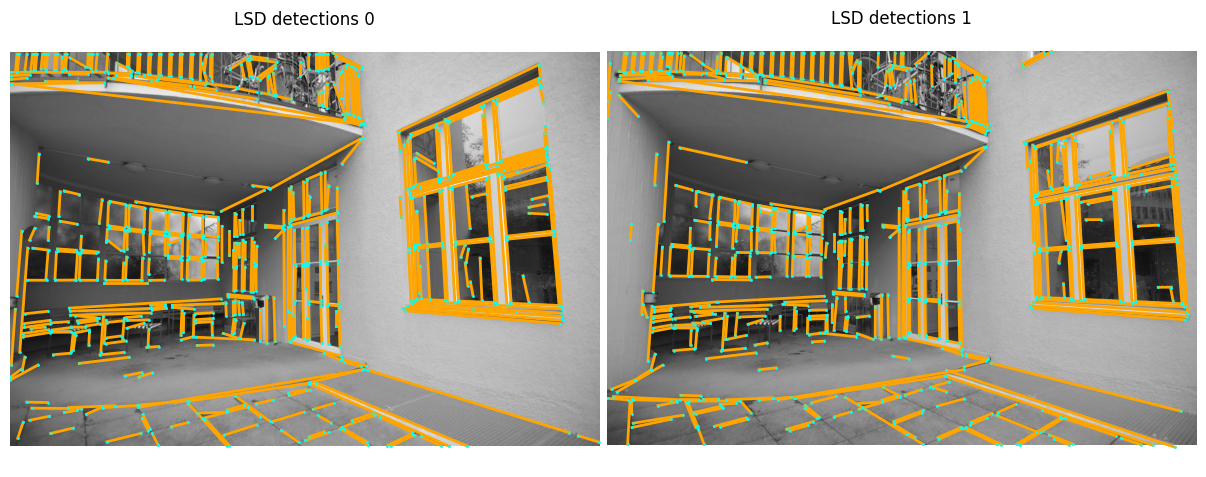

In [3]:
## LSD detections
lsd_sg_features0 = lsd_sg_matcher.detect_and_describe_lines(img0)
lsd_sg_features1 = lsd_sg_matcher.detect_and_describe_lines(img1)

# Display the detections
plot_images([img0, img1], ['LSD detections 0', 'LSD detections 1'])
plot_lines([lsd_sg_features0["line_segments"][:, :, [1, 0]], lsd_sg_features1["line_segments"][:, :, [1, 0]]])

## Line matching

/home/remi/Programmes/robust-line-based-estimator/robust_line_based_estimator/line_matching/superglue_endpoints.py:549: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float, device=self.device),
/home/remi/Programmes/robust-line-based-estimator/robust_line_based_estimator/line_matching/superglue_endpoints.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float, device=self.device),


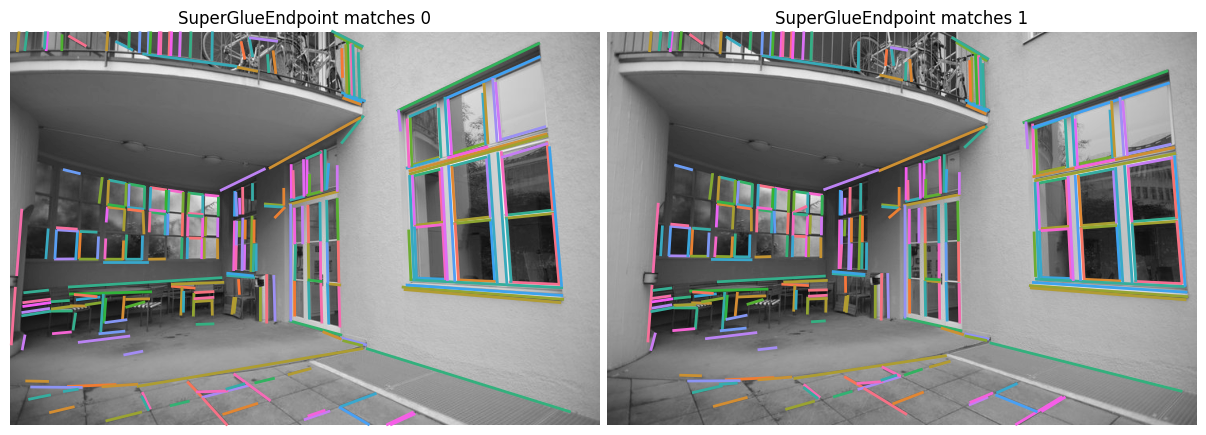

In [4]:
## SuperGlueEndpoint matching
_, m_lines0_sg, m_lines1_sg = lsd_sg_matcher.match_lines(img0, img1, lsd_sg_features0, lsd_sg_features1)

# Plot the matches
plot_images([img0, img1], ['SuperGlueEndpoint matches 0', 'SuperGlueEndpoint matches 1'])
plot_color_line_matches([m_lines0_sg[:, :, [1, 0]], m_lines1_sg[:, :, [1, 0]]])

## Vanishing point estimation

In [5]:
def verify_pyprogressivex(img, lines_segments, threshold = 2.0):     

    lines = []
    weights = []
    for i in range(lines_segments.shape[0]):
        p0 = lines_segments[i,0]
        p1 = lines_segments[i,1]
        len = np.linalg.norm(p1 - p0)
        lines.append([p0[0], p0[1], p1[0], p1[1]])
        weights.append(len)

    lines = np.array(lines)
    weights = np.array(weights)    

    vanishing_points, labeling = pyprogressivex.findVanishingPoints(
        np.ascontiguousarray(lines), 
        np.ascontiguousarray(weights), 
        img.shape[1], img.shape[0], 
        threshold = threshold,
        conf = 0.99,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 1.0,
        maximum_tanimoto_similarity = 1.0,
        max_iters = 1000,
        minimum_point_number = 5,
        maximum_model_number = -1,
        sampler_id = 0,
        scoring_exponent = 1.0,
        do_logging = False)    
    return vanishing_points, labeling

In [6]:
from random import randint
import matplotlib.pyplot as plt

def draw_results(img, model_number, labeling, linesegments, vanishing_points):
    line_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    max_inlier_number = 0

    for idx in range(model_number):    
        mask = np.zeros(len(labeling))
        indices = [i for i, e in enumerate(labeling) if e == idx]
        color = (randint(0, 255), randint(0, 255), randint(0, 255))

        vp = vanishing_points[idx]

        #print("Drawing the lines assigned to the {}-th vanishing point.".format(int(idx + 1)))
        #print(f"# inliers = {len(indices)}")
        
        for i in indices:
            # Draw the line
            pt1i = (int(linesegments[i, 0, 0]), int(linesegments[i, 0, 1]))
            pt2i = (int(linesegments[i, 1, 0]), int(linesegments[i, 1, 1]))
            width = 6 #linesegments[i, 4]
            
            cv2.line(line_img, pt1i, pt2i, color, int(np.ceil(width / 2)))
        
        if abs(vp[2]) < 1e-10:
            continue

        vp /= vp[2]
        vp = (int(vp[0]), int(vp[1]))

        cv2.circle(line_img, vp, 7, (255, 255, 255), -1)
        cv2.circle(line_img, vp, 5, color, -1)
        
    return line_img

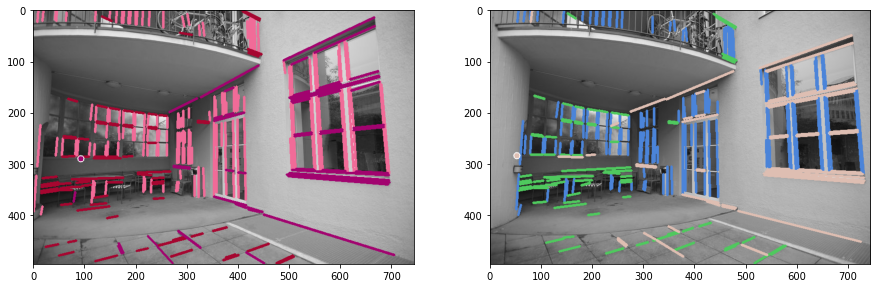

In [7]:
if True:
    plt.figure(figsize = (15,10))
    m_lines0_sg_inl = m_lines0_sg[:, :, [1, 0]]

    t = time()
    vanishing_points, labeling = verify_pyprogressivex(img0, m_lines0_sg_inl, threshold=1.5)
    model_number = int(vanishing_points.size / 3)

    vp_img0 = draw_results(img0, model_number, labeling, m_lines0_sg_inl, vanishing_points)
    plt.subplot(1, 2, 1)
    plt.imshow(vp_img0)

    m_lines1_sg_inl = m_lines1_sg[:, :, [1, 0]]

    t = time()
    vanishing_points, labeling = verify_pyprogressivex(img1, m_lines1_sg_inl, threshold=1.5)
    model_number = int(vanishing_points.size / 3)

    vp_img1 = draw_results(img1, model_number, labeling, m_lines1_sg_inl, vanishing_points)
    plt.subplot(1, 2, 2)
    plt.imshow(vp_img1)
    plt.show()

## Vanishing point matching

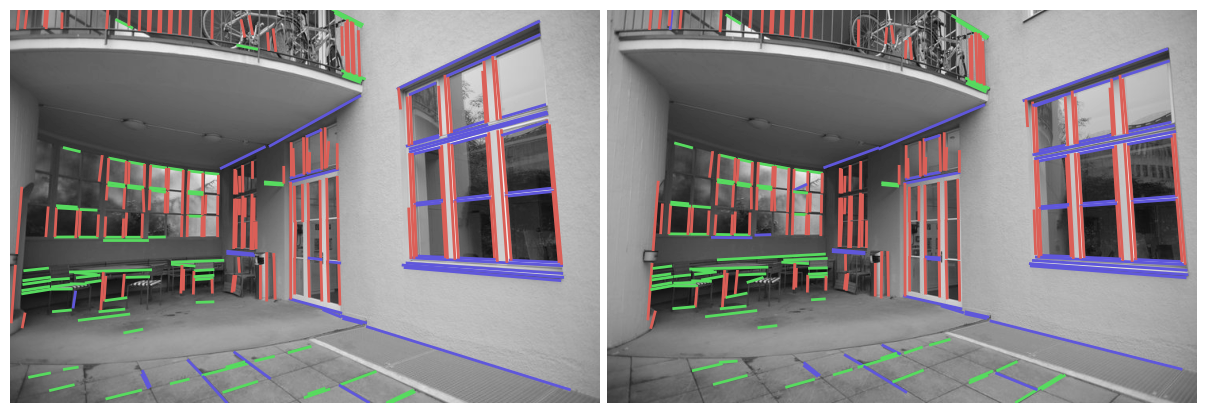

In [8]:
m_lines0_sg_inl = m_lines0_sg[:, :, [1, 0]]
vp0, label0 = verify_pyprogressivex(img0, m_lines0_sg_inl, threshold=1.5)
n_vp0 = len(vp0)

m_lines1_sg_inl = m_lines1_sg[:, :, [1, 0]]
vp1, label1 = verify_pyprogressivex(img1, m_lines1_sg_inl, threshold=1.5)
n_vp1 = len(vp1)

# Match vp0 with vp1 and update the VP labels: -1 is for lines without a matched VP and are ignored
m_vp0, m_label0, m_vp1, m_label1 = vp_matching(vp0, label0, vp1, label1)

# Visualize the matched VP with the same colors
plot_images([img0, img1])
plot_vp([m_lines0_sg_inl, m_lines1_sg_inl], [m_label0, m_label1])

## Joint VP detection and matching

In [5]:
def joint_vp_detection_and_matching(img, m_lines0, m_lines1, threshold = 2.0):
    """ m_lines0 and m_lines1 are two sets of matching [N, 2, 2] lines in x-y coordinate convention.
        Returns a set of matching VP [n_vp, 6] (first 3 params are for image 0, second 3 are for image 1).
    """
    lines = []
    weights = []
    for i in range(len(m_lines0)):
        l0, l1 = m_lines0[i], m_lines1[i]
        weights.append((np.linalg.norm(l0[1] - l0[1]) + np.linalg.norm(l1[1] - l1[1])) / 2)
        lines.append([l0[0, 0], l0[0, 1], l0[1, 0], l0[1, 1], l1[0, 0], l1[0, 1], l1[1, 0], l1[1, 1]])

    lines = np.array(lines)
    weights = np.array(weights)    

    vanishing_points, labeling = pyprogressivex.findCommonVanishingPoints(
        np.ascontiguousarray(lines), 
        np.ascontiguousarray(weights), 
        img.shape[1], img.shape[0], 
        threshold = threshold,
        conf = 0.99,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 1.0,
        maximum_tanimoto_similarity = 1.0,
        max_iters = 1000,
        minimum_point_number = 5,
        maximum_model_number = -1,
        sampler_id = 0,
        scoring_exponent = 1.0,
        do_logging = False)
    
    # Set the line labeling to -1 when the line has no corresponding VP
    n_vp = len(vanishing_points)
    labeling[labeling == n_vp] = -1
    
    return vanishing_points, labeling

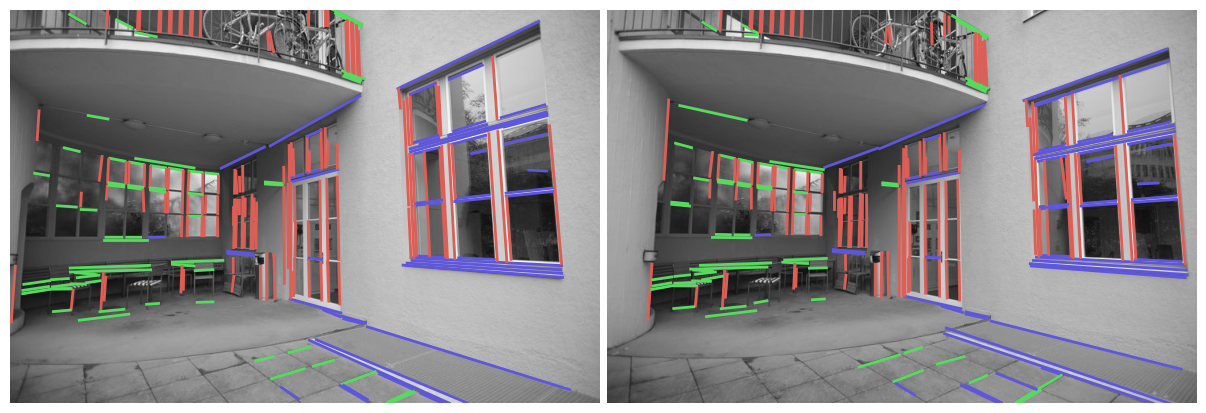

In [6]:
m_lines0_sg_inl = m_lines0_sg[:, :, [1, 0]]
m_lines1_sg_inl = m_lines1_sg[:, :, [1, 0]]
vp, label = joint_vp_detection_and_matching(img0, m_lines0_sg_inl, m_lines1_sg_inl, threshold=1.5)

# Visualize the matched VP with the same colors
plot_images([img0, img1])
plot_vp([m_lines0_sg_inl, m_lines1_sg_inl], [label, label])